In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [4]:
# Path to dataset
PATH = os.path.join(os.getcwd(), 'dataset')

# Specify training set and validation set
train_dir = os.path.join(PATH, 'train_1')
validation_dir = os.path.join(PATH, 'validation')

# Set Batch size and Image size
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Separate the training dataset in random batches
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 59922 files belonging to 2 classes.


In [5]:
# Separate the validation dataset in random batches
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 16726 files belonging to 2 classes.


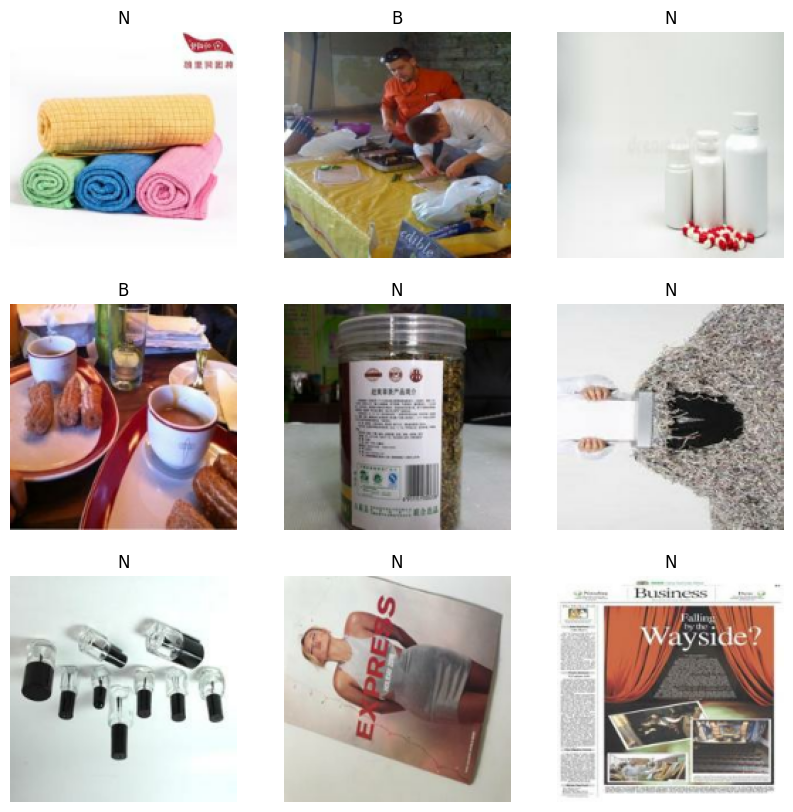

In [6]:
class_names = train_dataset.class_names

# Plot 9 random images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
# Create a test dataset from the validation set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 419
Number of test batches: 104


In [8]:
# Configure dataset to increase performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


2023-04-05 14:21:18.661301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [59922]
	 [[{{node Placeholder/_0}}]]
2023-04-05 14:21:18.663696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [59922]
	 [[{{node Placeholder/_4}}]]


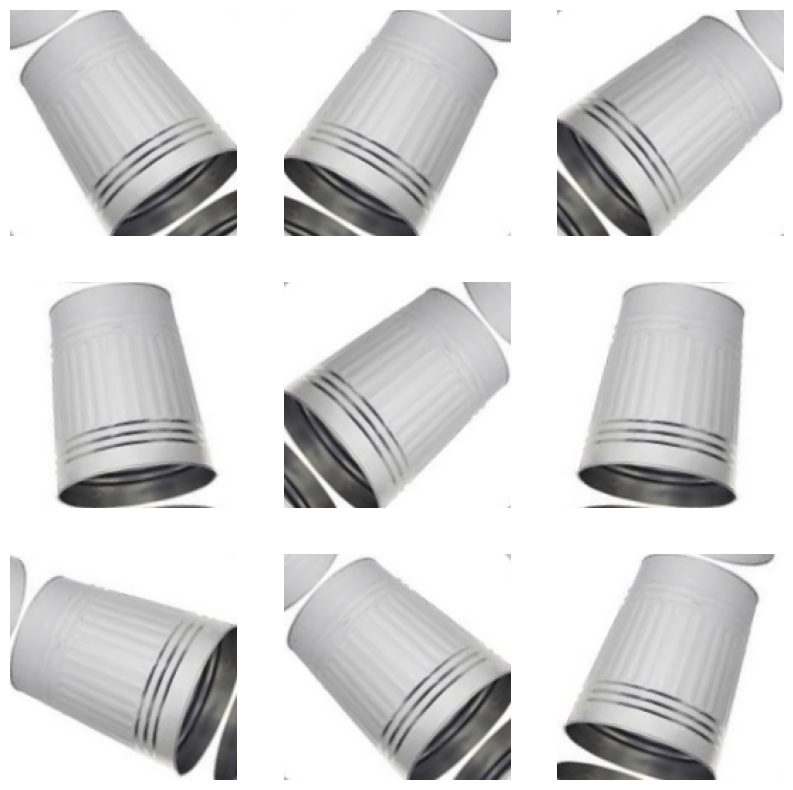

In [10]:
# show image augmentation for a random image
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


2023-04-05 14:22:37.765309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [59922]
	 [[{{node Placeholder/_0}}]]
2023-04-05 14:22:37.766532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [59922]
	 [[{{node Placeholder/_4}}]]


(32, 5, 5, 1280)


In [14]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2023-04-05 14:25:28.362641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16726]
	 [[{{node Placeholder/_4}}]]
2023-04-05 14:25:28.364434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16726]
	 [[{{node Placeholder/_4}}]]


336/336 [==============================] - 374s 1s/step - loss: 0.8410 - accuracy: 0.4968


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


initial loss: 0.84
initial accuracy: 0.50
Epoch 1/10
1873/1873 [==============================] - 1653s 882ms/step - loss: 0.1188 - accuracy: 0.9559 - val_loss: 0.1863 - val_accuracy: 0.9376
Epoch 2/10
1873/1873 [==============================] - 1710s 913ms/step - loss: 0.1102 - accuracy: 0.9602 - val_loss: 0.1847 - val_accuracy: 0.9386
Epoch 3/10
1873/1873 [==============================] - 1725s 921ms/step - loss: 0.1045 - accuracy: 0.9621 - val_loss: 0.1834 - val_accuracy: 0.9398
Epoch 4/10
1873/1873 [==============================] - 1735s 926ms/step - loss: 0.1018 - accuracy: 0.9626 - val_loss: 0.1828 - val_accuracy: 0.9397
Epoch 5/10
1873/1873 [==============================] - 1751s 935ms/step - loss: 0.1006 - accuracy: 0.9632 - val_loss: 0.1790 - val_accuracy: 0.9413
Epoch 6/10
1873/1873 [==============================] - 2325s 1s/step - loss: 0.0981 - accuracy: 0.9645 - val_loss: 0.1853 - val_accuracy: 0.9394
Epoch 7/10
1873/1873 [==============================] - 2210s 1s/st

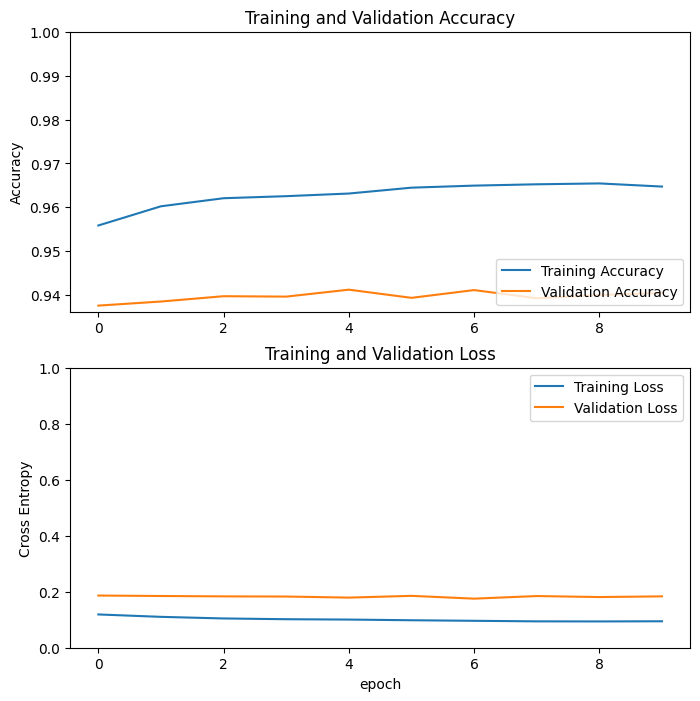

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [25]:
base_model.trainable = True


In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
1873/1873 [==============================] - 1795s 959ms/step - loss: 0.0861 - accuracy: 0.9684 - val_loss: 0.3061 - val_accuracy: 0.9055
Epoch 11/20
1873/1873 [==============================] - 3559s 2s/step - loss: 0.0685 - accuracy: 0.9754 - val_loss: 0.2025 - val_accuracy: 0.9367
Epoch 12/20
1873/1873 [==============================] - 4778s 3s/step - loss: 0.0598 - accuracy: 0.9787 - val_loss: 0.1837 - val_accuracy: 0.9423
Epoch 13/20
1873/1873 [==============================] - 5944s 3s/step - loss: 0.0532 - accuracy: 0.9811 - val_loss: 0.1428 - val_accuracy: 0.9533
Epoch 14/20
1873/1873 [==============================] - 5090s 3s/step - loss: 0.0469 - accuracy: 0.9837 - val_loss: 0.1558 - val_accuracy: 0.9515
Epoch 15/20
1873/1873 [==============================] - 5716s 3s/step - loss: 0.0424 - accuracy: 0.9851 - val_loss: 0.2003 - val_accuracy: 0.9419
Epoch 16/20
1873/1873 [==============================] - 4249s 2s/step - loss: 0.0390 - accuracy: 0.9862 - val_loss

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


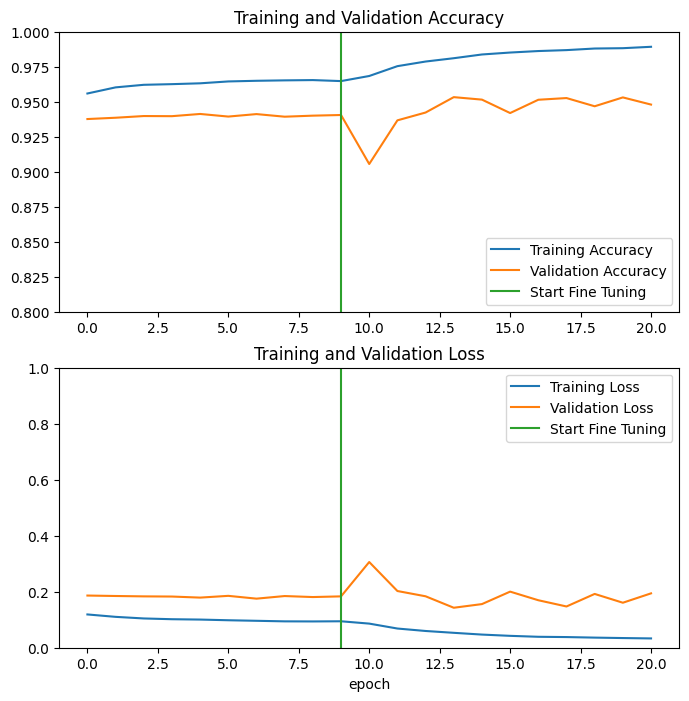

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [9]:
# Load the pre-trained model
model = tf.keras.models.load_model('saved_model/my_model')

Predictions:
 [0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1]
Labels:
 [0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1]


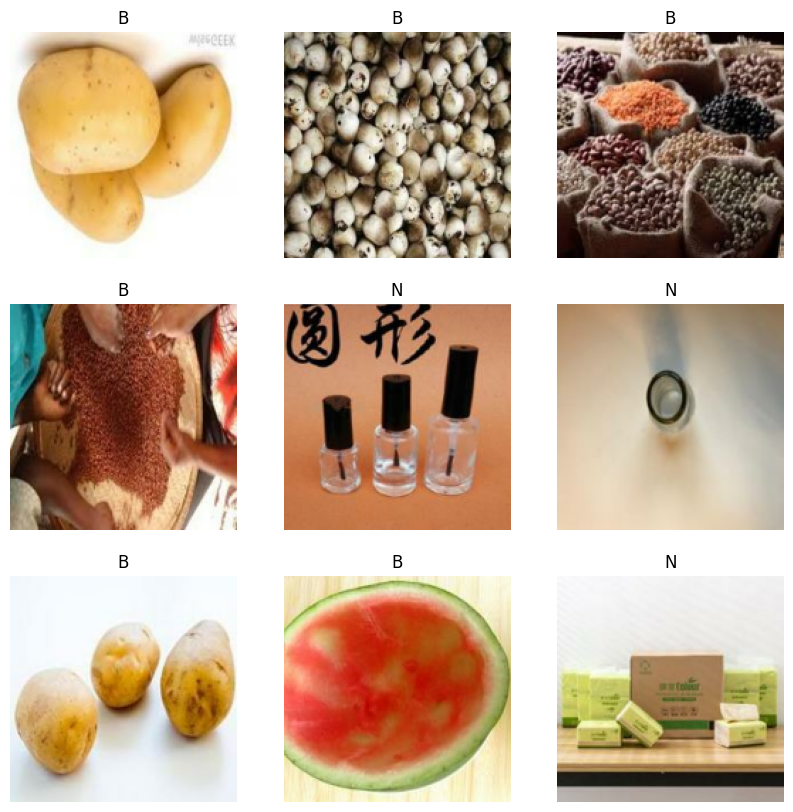

In [19]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")